# Описание проекта.

В проекте разработана нейронная сеть, которая предсказывает абсолютную температуру на поверхности новых открытых звезд. За основы взяты данные уже изученных 240 звёзд.

Для определения качества работы модели принята метрика RMSE. Значение метрики по условию не должно привышать 4500 К.

Для решения задачи применены следующие инструменты:
- pytorch;
- sklearn;
- phik;
- matplotlib;
- seaborn.

В ходе решения разработана нейронная сеть с 4 скрытыми слоями, к ней подобраны лучшие гиперпараметрами, а также добавлены улучшения в виде dropout и разбиения на batch-и.
Для изучения результатов работы в выоде приведена сводная таблица, показывающая, как изменения гиперпараметров и добавление улучшений влияют на матрику.

# Импорт данных.

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import copy
from math import ceil

import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

!pip install phik
import phik
from phik.report import plot_correlation_matrix

from phik import report

from urllib.parse import quote
import requests
from io import StringIO

In [2]:
file_path_local = '/Users/maksimgorskov/Desktop/Data Science/Спринт 17_Нейронные сети/Исходные данные /6_class.csv'
file_path_hab = '/datasets/6_class.csv'
 
try:
    stars_df = pd.read_csv(file_path_local)

except:
    stars_df = pd.read_csv(file_path_hab)


**Описание данных.**
- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.
 | Тип звезды                      | Номер, соответствующий типу |
|---------------------------------|------------------------------|
| Коричневый карлик               | 0                            |
| Красный карлик                  | 1                            |
| Белый карлик                    | 2                            |
| Звёзды главной последовательности | 3                            |
| Сверхгигант                     | 4                            |
| Гипергигант                     | 5                            |

- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

# Разведочный анализ.

## Общая оценка данных.

In [3]:
stars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


Столбец **'Unnamed: 0'** дублирует индексы датафрейма. Производится его удаление за ненужностью.

In [4]:
stars_df = stars_df.drop('Unnamed: 0', axis = 1)

## Оценка категориальных данных.

Данные приводятся в соответствии с стандартной классификацией цветов звезд по гарвардской системе.

In [5]:
# Анализ уникальных значений.
stars_df['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [6]:
#Приведение данных к нижнему регистру.
stars_df['Star color'] = stars_df['Star color'].str.lower()
stars_df['Star color'] = stars_df['Star color'].replace(
    ['blue white', 'yellowish white', 'pale yellow orange', 'blue ', 'blue white ', 'white-yellow', 'yellowish', 'whitish', 'pale-yellow-orange', 'yellow-white', 'orange-red'], 
    ['blue-white', 'yellowish-white', 'orange', 'blue', 'blue-white', 'yellowish-white', 'yellow', 'white', 'orange', 'yellowish-white', 'orange']
)

stars_df['Star color'].unique()

array(['red', 'blue-white', 'white', 'yellowish-white', 'orange', 'blue',
       'yellow'], dtype=object)

**Вывод:**

В параметре цвет, все значения приведены к стандартным, принятым в спетральном анализе звезд.

## Оценка количественных данных.

**Для оценки данных в зависимости от типа звезды строятся гистограммы распределения для каждого класса звезды.**

Распределение признаков звезд 0 класса


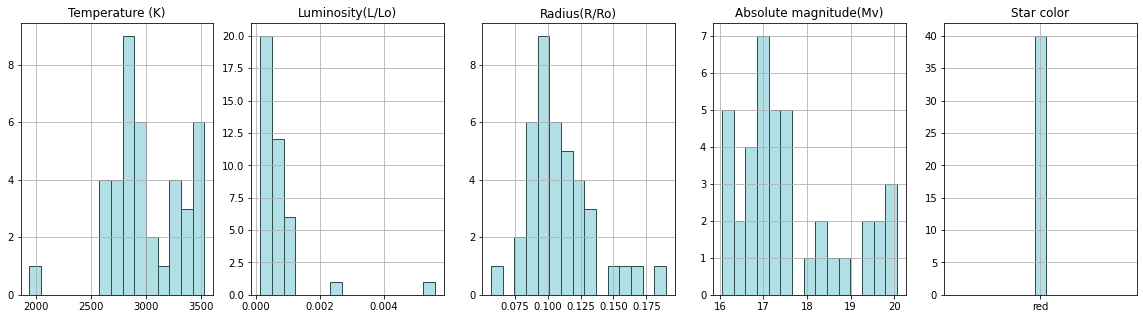

_____________________________________________________________
Распределение признаков звезд 1 класса


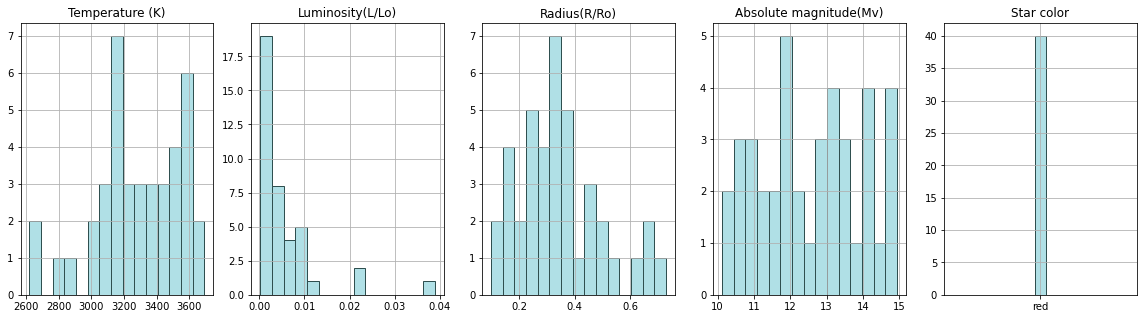

_____________________________________________________________
Распределение признаков звезд 2 класса


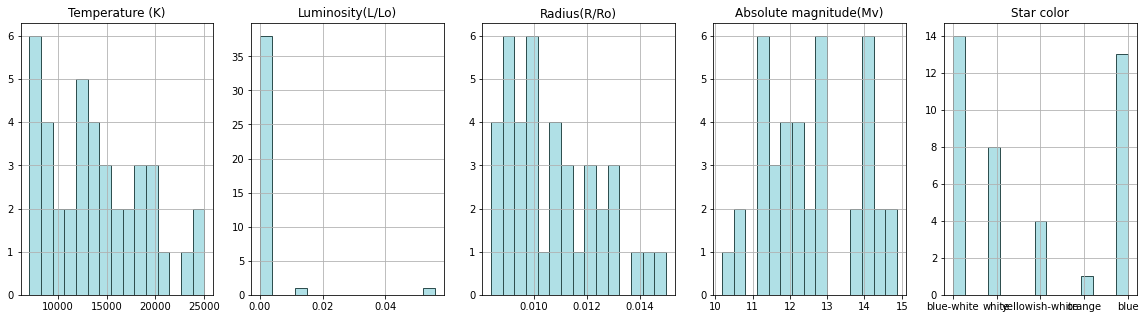

_____________________________________________________________
Распределение признаков звезд 3 класса


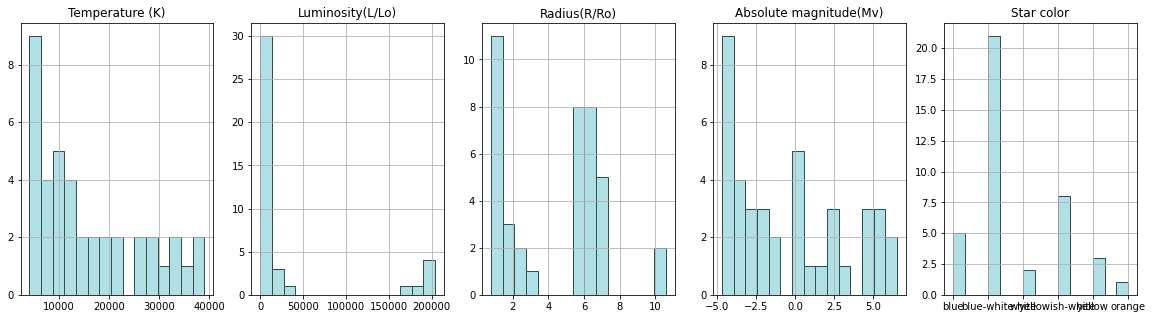

_____________________________________________________________
Распределение признаков звезд 4 класса


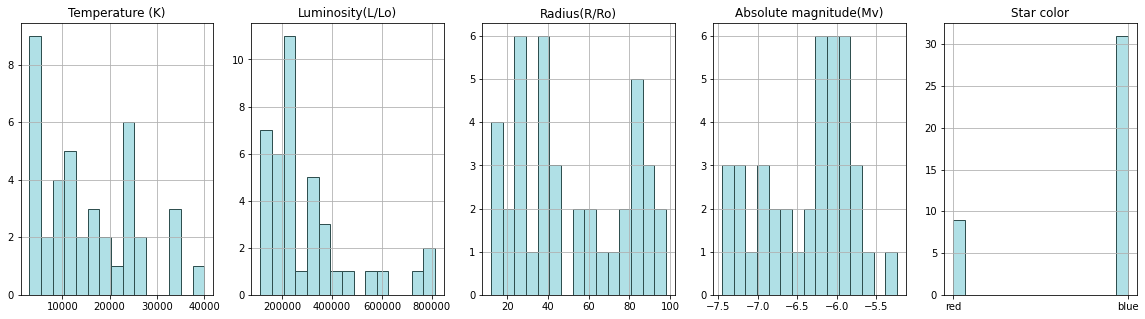

_____________________________________________________________
Распределение признаков звезд 5 класса


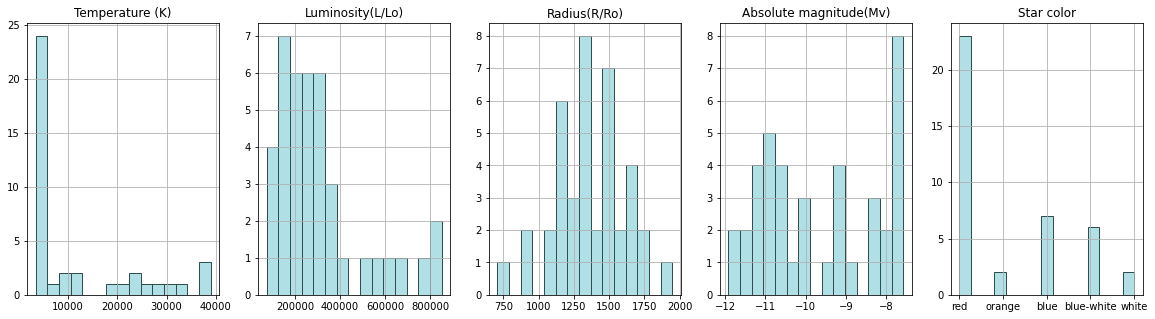

_____________________________________________________________


In [7]:
num_columns = 5
num_rows = 1

# Уникальные классы звезд.
star_classes = stars_df['Star type'].unique()

# Построение графика распределения значений параметров для каждого типа звезды.
for s_class in star_classes: 
    print(f'Распределение признаков звезд {s_class} класса')
    
    # Фигура и оси для каждого класса звезды.
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5))
    
    # Параметры для текущего класса звезды.
    star_parameter = stars_df[stars_df['Star type'] == s_class].drop('Star type', axis=1)
    
    # Обработка каждой оси в данной фигуре
    for i, ax in enumerate(axes.flatten()):
        if i < len(star_parameter.columns):
            # Гистограмма для текущей оси
            star_parameter[star_parameter.columns[i]].hist(bins=15,
                                                            color='powderblue',
                                                            edgecolor='darkslategray',
                                                            linewidth=1,
                                                            ax=ax)
            ax.set_title(star_parameter.columns[i])
    
    plt.show()
    print('_____________________________________________________________')

**Оценка распределения данных по каждому классу.**
- класс 0. 
        1) Есть аномальные значения светимости превышающие значение 0.002.
- класс 1.
        1)Есть аномальные значения светимости превышающие значение 0.02.
- класс 2.
        1)Есть аномальные значения светимости превышающие значение 0.015.

### Обработка аномальных значений.

In [8]:
#Удаление аномальных значений светимости для класса 0.
class_num = [0, 1, 2]
lumin_threshold_value = [0.002, 0.01, 0.01]
for i in class_num: 
    class_lumin_median = stars_df.loc[stars_df['Star type'] == i, 'Luminosity(L/Lo)'].median()
    stars_df.loc[(stars_df['Star type'] == i) & 
                 (stars_df['Luminosity(L/Lo)'] > lumin_threshold_value[i]), 
                                             'Luminosity(L/Lo)'] = class_lumin_median

### Оценка распределения признаков каждого класса звезд в совокупности со всеми классами.

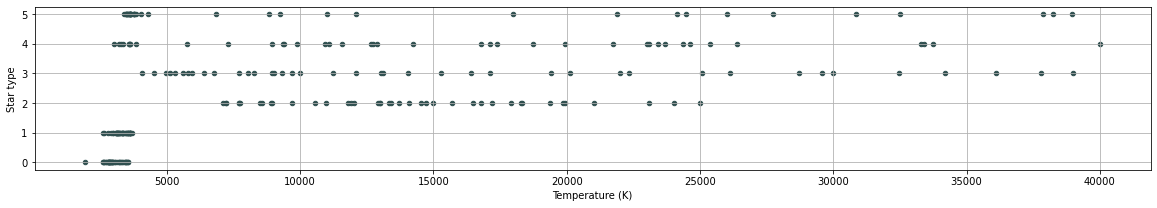

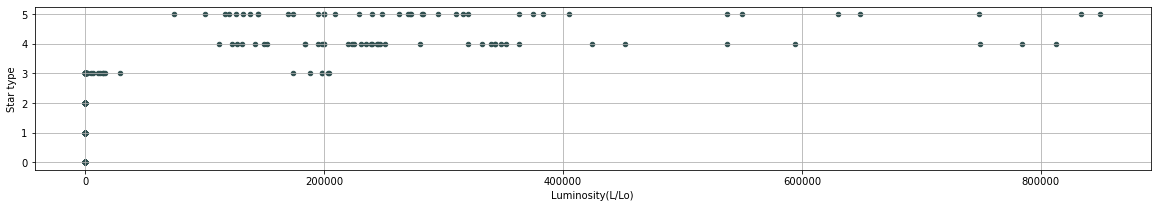

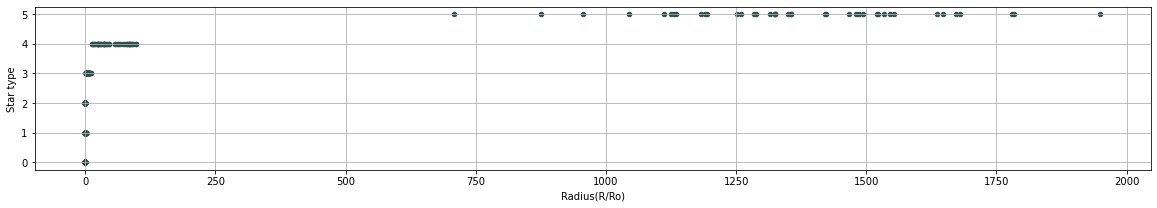

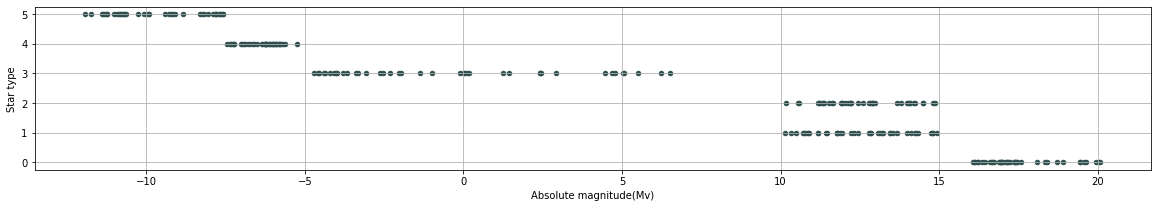

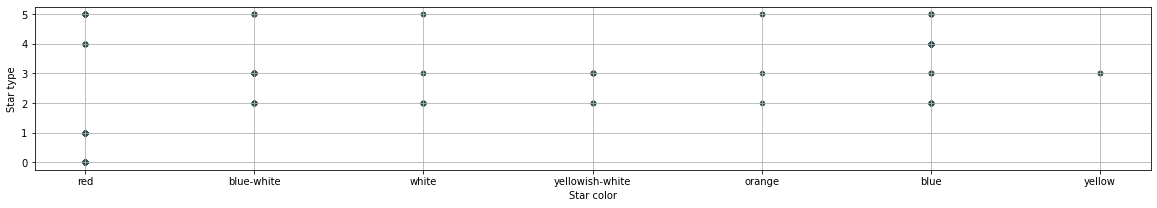

In [9]:
# Data anomaly reserch
main_features_corr = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star color'] 
for i in main_features_corr:
    stars_df.plot(kind = 'scatter', y = 'Star type', x = i, 
                  grid = True, legend=True, figsize = (20,3), color='darkslategray')

**Вывод:**

    1) Необходимо обработать данные с цетами звезд класса 2. Т.к. часть цветовых значений не соответствую данному классу звезд.
    2) Необходимо проверить данные на соответстие спектральному классу звезд.
    3) Данные, за исключением п.1, не имеют явного отклонения в распределении значений.


## Анализ наличия дубликатов.

In [10]:
stars_df.duplicated().sum()

0

### Вывод.

Дубликаты в датасете отсутствуют.

## Анализ нулевых значений относительных величин.

При оценке количественных данных на графиках обнаружены значения близкие к 0 в следующих признаках: 'Luminosity(L/Lo)'и 'Radius(R/Ro)'.
Т.к. данные значения отображают параметры относительно солнца значения не моут принимать 0 значение.
Ниже проведена провверка на раввенство 0.

In [11]:
for i in ['Luminosity(L/Lo)', 'Radius(R/Ro)']:
    nulls = stars_df[i].isnull().sum()
    if nulls != 0:
        print(f'Количество нулевых значений: {nulls}')
    else:
        print(f'Для значений {i} 0 значения отсутствуют.')

Для значений Luminosity(L/Lo) 0 значения отсутствуют.
Для значений Radius(R/Ro) 0 значения отсутствуют.


**Вывод:**

0-е значения отсутствуют. Данные могут быть оставлены.

## Анализ физических параметров звезд.

### Анализ температуры звезд

Для оценки анализа звезд возможно произвести оценку адекватности исходных данных.

По закону Стефана-Больцмана возможно рассчитать температуры звезд и сраввнить их с существующими значениями.

In [12]:
L_0 = 3.828e26 #светимость солнца
R_0 = 6.9551e8 #радиус солнца
StB_const = 5.67e-8 #постоянная Стефана-Больцмана
Pi = 3.14 

Добавление рассчетных значений температур в датафрейм.

In [13]:
stars_df['Stefan Boltzmann law'] = (
    (stars_df['Luminosity(L/Lo)'] * L_0) / 
    (4 * Pi * StB_const * (stars_df['Radius(R/Ro)'] * R_0) ** 2)
)**0.25

С помощью метрики RMSE оценивается, насколько фактические температуры отличаются от рассчетных.

In [14]:
y_pred = stars_df['Stefan Boltzmann law'] 
y_fact = stars_df['Temperature (K)']
mse = mean_squared_error(y_fact, y_pred)
mse
rmse = mse**(0.5)
print(f'RMSE: {rmse}')

RMSE: 8371.52677138732


Ошибка слишком велика. Однако в рамках проекта невозможно определить, является ли исходная температура ошибочной, или нет. Поэтому никакая обработка трагета не производится. Тем более расчетная температура по закону Стефана-Больцмана является лишь частью методолгии определения температуры звезд и не может быть принята за единственное истинное значение.

Параметр рассчетной температуры оставляется как синтетически разработанная фича.

### Спектральные классы звезд.

Чтобы оценить насколько исходные данные соответствуют действительности строится график зависимости температуры от светимости звезд. На график накладываются цвета и размеры звезд. График сравнивается с спектральным классом звезд, принятым в астрономии.


Для построения графика используется библиотека matplotlib. Для ее корректного использования необходимо добавить в датафрейм цвета в соответствии с цветовыми кодами данной библиотеки.

In [15]:
#Датафрейм с цветами. Корреляция заданных цветов и цветов mplt. 
color_list = stars_df['Star color'].unique()
colors_df = pd.DataFrame(color_list, columns=['Star color'])
colors_df['plt_color'] = [
    'red',
    'skyblue',
    'white',
    'lemonchiffon',
    'orange',
    'deepskyblue',
    'yellow',
    
]
colors_df

,Star color,plt_color
0,red,red
1,blue-white,skyblue
2,white,white
3,yellowish-white,lemonchiffon
4,orange,orange
5,blue,deepskyblue
6,yellow,yellow


In [16]:
# Добавление в датасет цветов по номенклатуре matplotlib.
def mplt(row):
    for i in colors_df['Star color']:
        if row['Star color'] == i:
            plt_color_i = colors_df.loc[colors_df['Star color'] == i].index[0]
            return colors_df['plt_color'][plt_color_i]


In [17]:
stars_df['plt_color'] = stars_df.apply(mplt, axis=1)
stars_df.head(5)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Stefan Boltzmann law,plt_color
0,3068,0.000520,0.1700,16.12,0,red,2114.581818,red
1,3042,0.000500,0.1542,16.60,0,red,2198.611183,red
2,2600,0.000300,0.1020,18.70,0,red,2379.185729,red
3,2800,0.000200,0.1600,16.65,0,red,1716.507186,red
4,1939,0.000138,0.1030,20.06,0,red,1949.841357,red


Ниже приведен общепринятый в астраномии спектральный класс звезд.
В рамках проекта он берется за эталон и с ним сравнивается график спектрального класса звезд, построенный на исходных данных.

![](https://upload.wikimedia.org/wikipedia/commons/f/fe/HRDiagram_ru.png)

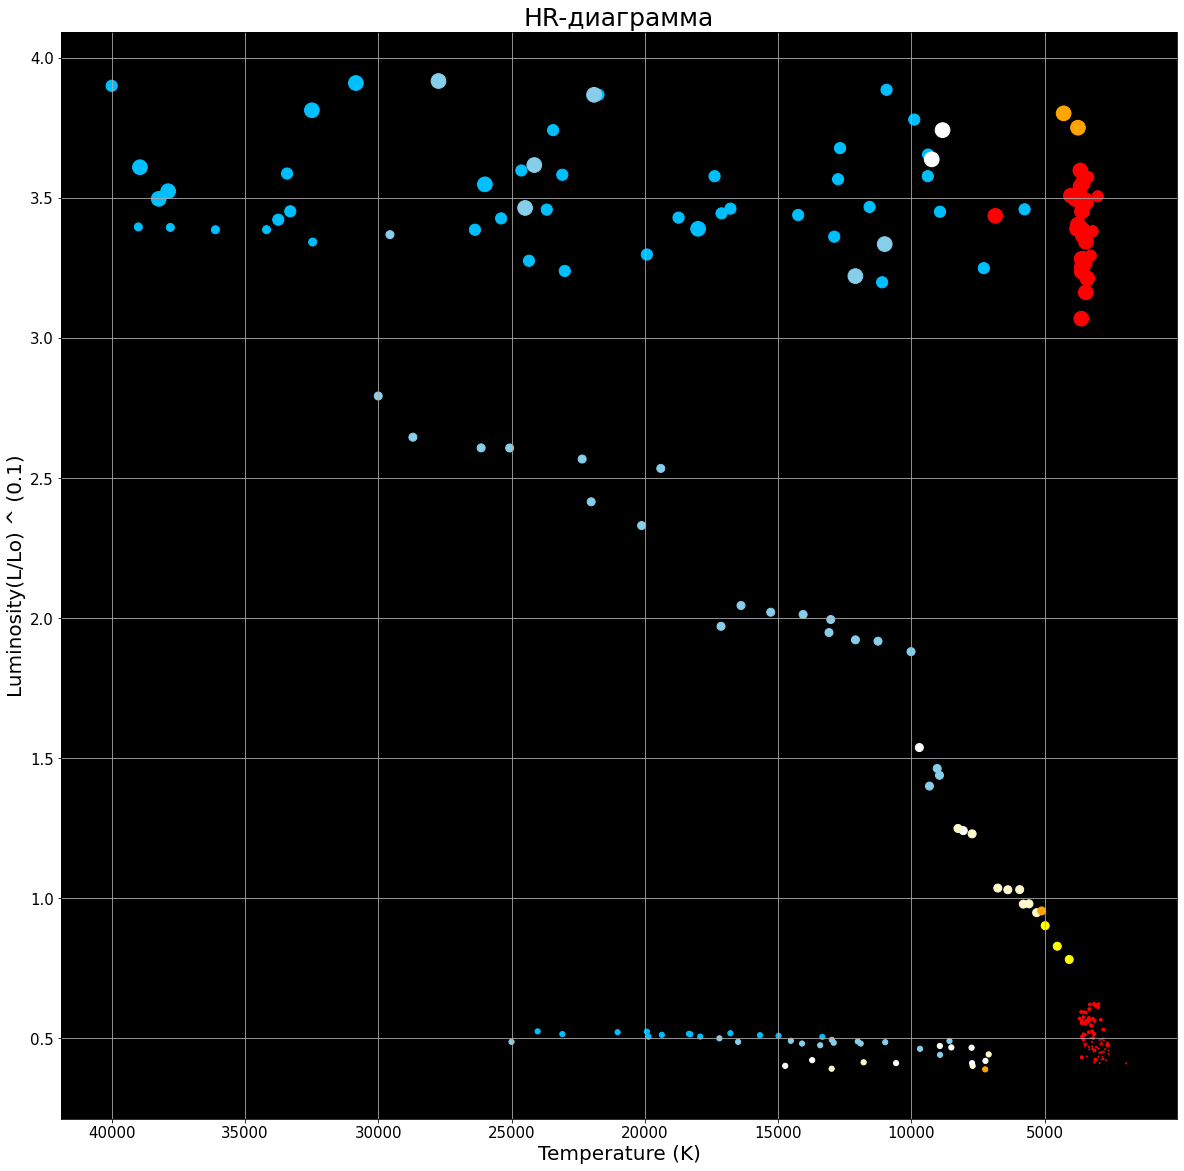

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Создайте общую диаграмму
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_facecolor('black')  # Черный фон

# Легенда
legend_labels = ['Карлик', 'Красный карлик', 'Белый карлик', 'Главная последовательность', 'Сверхгигант', 'Гипергигант']
legend_handles = []

# Постройка HR-диаграммы для каждого типа звезды
for i in range(6):
    temperature = stars_df[stars_df['Star type'] == i]['Temperature (K)']
    luminosity = stars_df[stars_df['Star type'] == i]['Luminosity(L/Lo)']

    # Логарифмические шкалы
    log_temperature = temperature
    log_luminosity = luminosity**(0.1) # Возведение в степень необходима чтобы сжыть график по Оy
 
    # Цвета и размеры точек
    colors = stars_df[stars_df['Star type'] == i]['plt_color']
    sizes = (stars_df[stars_df['Star type'] == i]['Star type'] + 1)**3

    # Добавление точек на диаграмму
    scatter = ax.scatter(log_temperature, log_luminosity, c=colors, s=sizes, alpha=1)
    
    # Добавление в легенду
    legend_handles.append(scatter)

# Настройка внешнего вида
ax.set_title('HR-диаграмма', fontsize=25)
ax.set_xlabel('Temperature (K)', fontsize=20)
ax.set_ylabel('Luminosity(L/Lo) ^ (0.1)', fontsize=20)
ax.invert_xaxis()  # Инвертировать ось температуры, чтобы высокие значения были слева
ax.tick_params(axis='both', labelsize=15)
ax.grid(True)

# Добавление легенды
#legend = ax.legend(handles=legend_handles, title='Тип звезды', labels=legend_labels)
#ax.add_artist(legend)

plt.show()

На диаграмме видно, что часть звезд по цвету не соотвтетсвуют своей температуре. Также заметно что в районе, где должны располагаться гиганты и сверхгиганты, светила находятся вперемпешку между собой.

Для того, чтобы убедиться в достоверности данных ниже производится сверка исходных дынных с гарвардской классификацией звезд, приведенной ниже.

![](https://cosmosfrontier.com/wp-content/uploads/sites/32/2020/04/stellar-classification.jpg)

Приведение температур в соответствие с гарвардской классификацией звезд.

In [19]:
def star_colors_transformer(row):
    temperature = row['Temperature (K)']
    if temperature <= 3500:
        return 'red'
    elif temperature <= 5000:
        return 'orange'
    elif temperature <= 6000:
        return 'yellow'
    elif temperature <= 7500:
        return 'yellowish-white'
    elif temperature <= 10000:
        return 'white'
    elif temperature <= 30000:
        return 'blue-white'
    else:
        return 'blue'

In [20]:
#Корректировка цветов в df
stars_df['Star color'] = stars_df.apply(star_colors_transformer, axis = 1)
stars_df['plt_color'] = stars_df.apply(mplt, axis=1)
stars_df.head(5)


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Stefan Boltzmann law,plt_color
0,3068,0.000520,0.1700,16.12,0,red,2114.581818,red
1,3042,0.000500,0.1542,16.60,0,red,2198.611183,red
2,2600,0.000300,0.1020,18.70,0,red,2379.185729,red
3,2800,0.000200,0.1600,16.65,0,red,1716.507186,red
4,1939,0.000138,0.1030,20.06,0,red,1949.841357,red


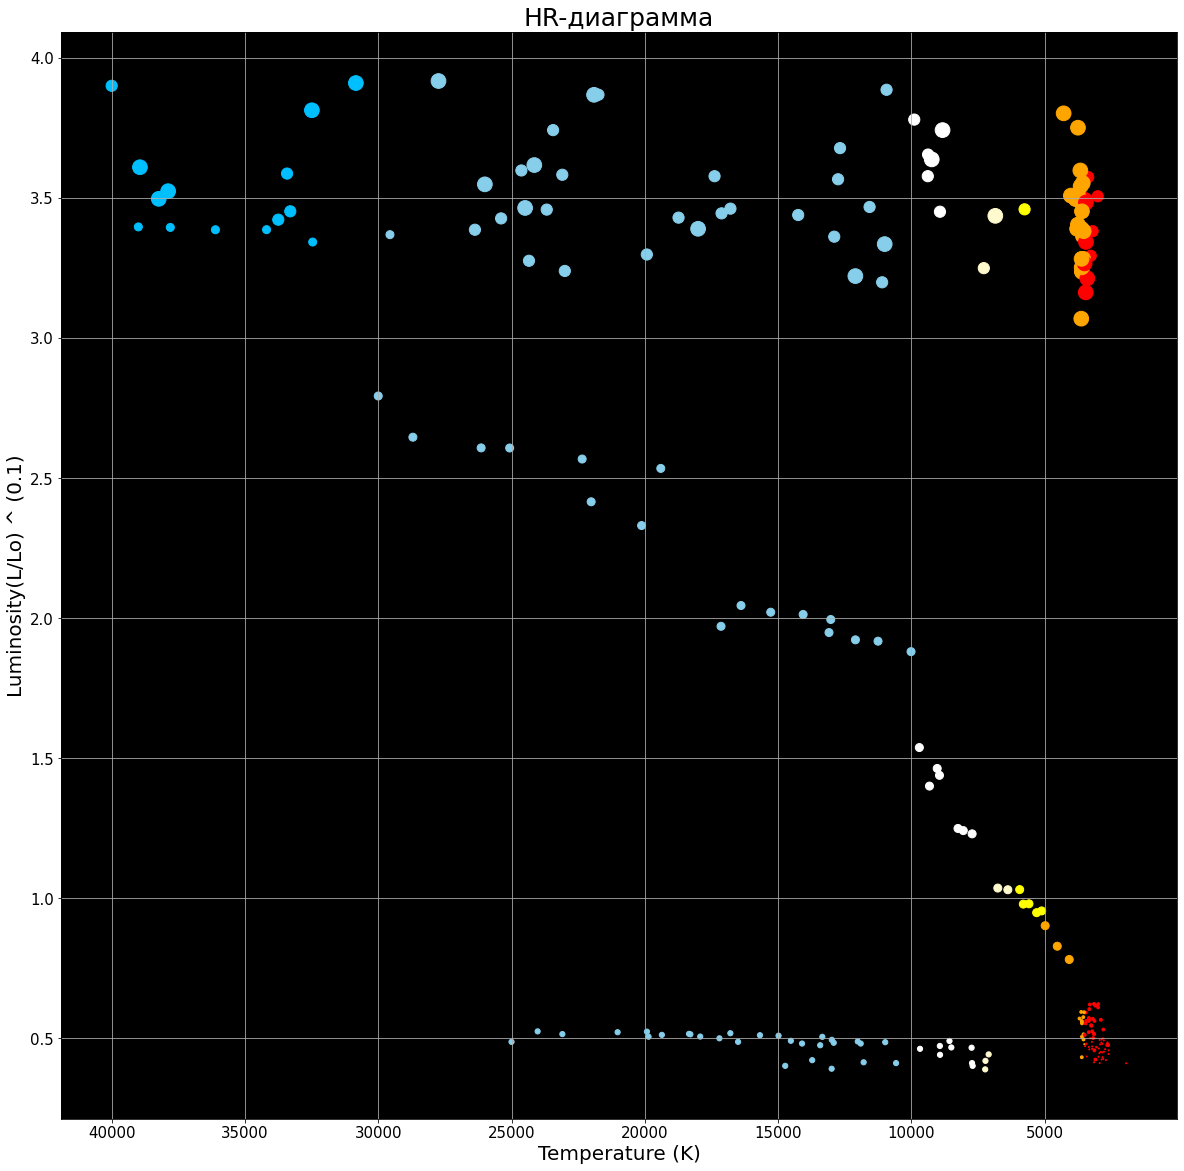

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Создайте общую диаграмму
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_facecolor('black')  # Черный фон

# Легенда
legend_labels = ['Карлик', 'Красный карлик', 'Белый карлик', 'Главная последовательность', 'Сверхгигант', 'Гипергигант']
legend_handles = []

# Постройка HR-диаграммы для каждого типа звезды
for i in range(6):
    temperature = stars_df[stars_df['Star type'] == i]['Temperature (K)']
    luminosity = stars_df[stars_df['Star type'] == i]['Luminosity(L/Lo)']

    # Логарифмические шкалы
    log_temperature = temperature
    log_luminosity = luminosity**(0.1) # Возведение в степень необходима чтобы сжыть график по Оy
 
    # Цвета и размеры точек
    colors = stars_df[stars_df['Star type'] == i]['plt_color']
    sizes = (stars_df[stars_df['Star type'] == i]['Star type'] + 1)**3

    # Добавление точек на диаграмму
    scatter = ax.scatter(log_temperature, log_luminosity, c=colors, s=sizes, alpha=1)
    
    # Добавление в легенду
    legend_handles.append(scatter)

# Настройка внешнего вида
ax.set_title('HR-диаграмма', fontsize=25)
ax.set_xlabel('Temperature (K)', fontsize=20)
ax.set_ylabel('Luminosity(L/Lo) ^ (0.1)', fontsize=20)
ax.invert_xaxis()  # Инвертировать ось температуры, чтобы высокие значения были слева
ax.tick_params(axis='both', labelsize=15)
ax.grid(True)


# Добавление легенды
#legend = ax.legend(handles=legend_handles, title='Тип звезды', labels=legend_labels)
#ax.add_artist(legend)

plt.show()

In [22]:
#Удаление параметра 'plt_color'.
stars_df = stars_df.drop('plt_color', axis = 1)

По характеристикам звезды с индексами 29 и 80 должны относиться к типу звезд - 2 и иметь белый цвет.

**Вывод:**

Данные преобразованы и соответствуют гарвардской классификацией звезд.

## Анализ признаков на мультиколлинеарность.

Для анализа признаков на мультиколлинеарность используется библиотека phik.Она позволяет выявить степень корреляции между категориальными и числовыми признаками.

In [23]:
%%time
#Матрица корреляции / Correlation matrix
phik_base = stars_df.phik_matrix()
phik_base.head()

interval columns not set, guessing: ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type', 'Stefan Boltzmann law']
CPU times: user 66.3 ms, sys: 164 ms, total: 230 ms
Wall time: 2.46 s


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Stefan Boltzmann law
Temperature (K),1.000000,0.561692,0.236090,0.709280,0.603203,0.854931,0.703638
Luminosity(L/Lo),0.561692,1.000000,0.574964,0.709456,0.654026,0.380054,0.478895
Radius(R/Ro),0.236090,0.574964,1.000000,0.512414,0.635115,0.310865,0.000000
Absolute magnitude(Mv),0.709280,0.709456,0.512414,1.000000,0.915921,0.716944,0.664115
Star type,0.603203,0.654026,0.635115,0.915921,1.000000,0.622169,0.794675


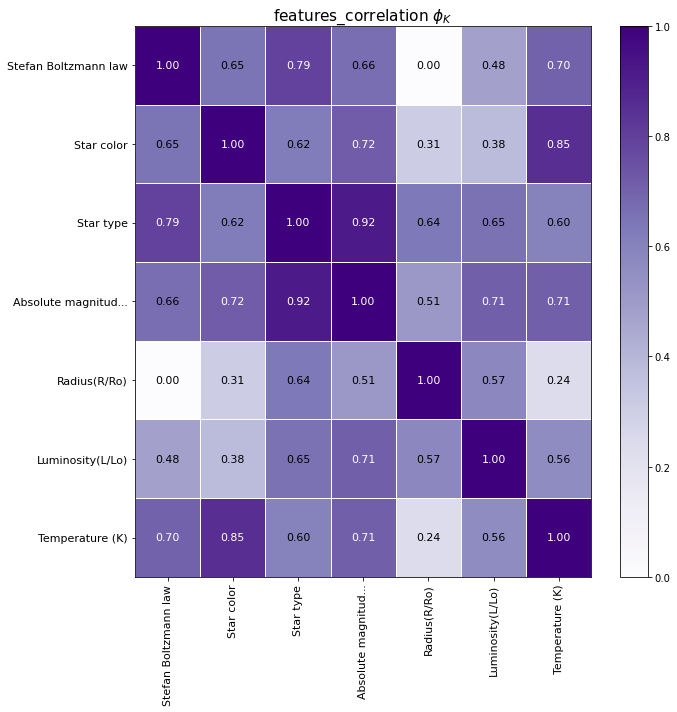

In [24]:
#Визуализация матрицы 𝜙k / 𝜙k matrix visualisation
plot_correlation_matrix(phik_base.values, 
                        x_labels=phik_base.columns, 
                        y_labels=phik_base.index, 
                        vmin=0, vmax=1, color_map="Purples", 
                        title=r"features_correlation $\phi_K$", 
                        fontsize_factor=1.1, 
                        figsize=(10, 10))
plt.tight_layout()

**Результат анализа:**

- Мультиколлинеарность между признаками отсутствует.
- Целевой признак (Температура на поверхности) в большей степени зависит от цвета звезды, а в меньшей степени зависит от ее радиуса.

## Вывод
- Пропуски в данных отсутствуют.
- Значения в каждом признаке соответствуют требуемым физическим характеристикам звезд.
- Аномальные значения в данных отсутствуют.
- Мультиколлинеарность в признаках отсутствует.
- Дубли в данных исключены.

# Подготовка данных к построению модели.

## Объявление переменных.

In [25]:
#random_state для train_test_split
rand_st = 42


## Подготовка обучаюшей и валидационной выборки.

In [26]:
#Определение целевого признака и набора фичей.
y = stars_df['Temperature (K)']
X = stars_df.drop(['Temperature (K)'], axis = 1) 

#Валидационная и тестовая выборки.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = rand_st) 

## Кодирование данных. OHE & StandardScaler. Pipeline

In [27]:
#Выделение количественных призгнаков.
NUMERIC_COLUMNS = X_train.select_dtypes(include = ['int', 'float']).columns.tolist()
NUMERIC_COLUMNS.remove('Star type')
#Выделение категориальных признаков. 
CAT_COLUMNNS = X_train.select_dtypes(include = 'object').columns.tolist()
CAT_COLUMNNS.append('Star type')


In [28]:
print(f'Список числовых признаков: {NUMERIC_COLUMNS}')
print(f'Список категориальных признаков: {CAT_COLUMNNS}')

Список числовых признаков: ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Stefan Boltzmann law']
Список категориальных признаков: ['Star color', 'Star type']


In [29]:
#Cоздание трансформера для числовых столбцов
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())]) #StandardScaler()

#Cоздание трансформера для категориальных столбцов
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='error', drop='first'))])

In [30]:
#создание общего трансформера
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_COLUMNS),
        ('cat', categorical_transformer, CAT_COLUMNNS)],
        remainder='passthrough'
)

#создание полного пайплайна
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

#применение пайплайна
X_train_transformed = pipeline.fit_transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)

In [31]:
onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']

In [32]:
categorical_features = onehot.get_feature_names(CAT_COLUMNNS)
categorical_features

/Users/maksimgorskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['Star color_blue-white', 'Star color_orange', 'Star color_red',
       'Star color_white', 'Star color_yellow',
       'Star color_yellowish-white', 'Star type_1', 'Star type_2',
       'Star type_3', 'Star type_4', 'Star type_5'], dtype=object)

In [33]:
all_features = np.concatenate([NUMERIC_COLUMNS, categorical_features, CAT_COLUMNNS])
all_features

array(['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)',
       'Stefan Boltzmann law', 'Star color_blue-white',
       'Star color_orange', 'Star color_red', 'Star color_white',
       'Star color_yellow', 'Star color_yellowish-white', 'Star type_1',
       'Star type_2', 'Star type_3', 'Star type_4', 'Star type_5',
       'Star color', 'Star type'], dtype=object)

In [34]:
all_features = np.concatenate([NUMERIC_COLUMNS, CAT_COLUMNNS])
all_features

array(['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)',
       'Stefan Boltzmann law', 'Star color', 'Star type'], dtype='<U22')

In [35]:
#преобразуем нашу разреженную матрицу, выходящую из пайплайна, в датафрейм

onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']

categorical_features = onehot.get_feature_names(CAT_COLUMNNS)
all_features = np.concatenate([NUMERIC_COLUMNS, categorical_features])

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_features)
X_valid_transformed_df = pd.DataFrame(X_valid_transformed, columns=all_features)

# Построение простой модели нейронной сети — baseline.

## Class для задания архитектуры нейронной сети.

Создание класса-потомка для класса nn.Module.

In [36]:
class NeuralNet (nn.Module):
    def __init__ (self, 
                  n_in_neurons, 
                  n_hidden_neurons_1, 
                  n_hidden_neurons_2, 
                  n_hidden_neurons_3, 
                  n_hidden_neurons_4, 
                  n_out_neurons, p):
        super(NeuralNet, self).__init__()
        
        #Создание полносвязного графа
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.fc = nn.Linear(n_hidden_neurons_4, n_out_neurons)
    
        #Создание функции активации
        self.act1 = nn.SiLU()
        self.act2 = nn.SiLU()
        self.act3 = nn.SiLU()
        self.act4 = nn.SiLU()
        
        #формула для расчета стандартного отклонения 
        #std = (2/(n+(n+1)))**0.5, где n - кол-во нейронов в 1 слое
          
        #Инициализация весов и отступов
        std1 = (2/(n_in_neurons + n_hidden_neurons_1))**0.5
        nn.init.normal_(self.fc1.weight, mean=0, std=std1)
        nn.init.normal_(self.fc1.bias, mean=0, std=std1)
        
        std2 = (2/(n_hidden_neurons_1 + n_hidden_neurons_2))**0.5
        nn.init.normal_(self.fc2.weight, mean=0, std=std2)
        nn.init.normal_(self.fc2.bias, mean=0, std=std2)
        
        std3 = (2/(n_hidden_neurons_2 + n_hidden_neurons_3))**0.5
        nn.init.normal_(self.fc3.weight, mean=0, std=std3)
        nn.init.normal_(self.fc3.bias, mean=0, std=std3)
        
        std4 = (2/(n_hidden_neurons_3 + n_hidden_neurons_4))**0.5
        nn.init.normal_(self.fc4.weight, mean=0, std=std4)
        nn.init.normal_(self.fc4.bias, mean=0, std=std4)
        
        #Введение dropout
        self.dp1 = nn.Dropout(p=p)
        self.dp2 = nn.Dropout(p=p)
        self.dp3 = nn.Dropout(p=p)
        self.dp4 = nn.Dropout(p=p)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.dp1(out)
        
        out = self.fc2(out)
        out = self.act2(out)
        out = self.dp2(out)
        
        out = self.fc3(out)
        out = self.act3(out)
        out = self.dp3(out)
                
        out = self.fc4(out)
        out = self.act4(out)
        out = self.dp4(out)
        
        out = self.fc(out)
        
        return out

## Base Line нейронной сети.


In [37]:
#Перевод данных в тензор.
X_train = torch.FloatTensor(X_train_transformed_df.values)
X_valid = torch.FloatTensor(X_valid_transformed_df.values)
y_train = torch.FloatTensor(y_train.values)
y_valid = torch.FloatTensor(y_valid.values)

In [38]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 36
n_hidden_neurons_2 = 12
n_hidden_neurons_3 = 8
n_hidden_neurons_4 = 2
n_out_neurons = 1

Задание переменных для нейронной сети.

In [39]:
#Заданеи слоев для нейронной сети 
net_layers = [n_in_neurons, 
              n_hidden_neurons_1, 
              n_hidden_neurons_2, 
              n_hidden_neurons_3, 
              n_hidden_neurons_4, 
              n_out_neurons] 

#количество эпох обучения нейронки
num_epoch =10000

#скорость обучения
learning_rate = 0.001

In [40]:
#Фиксация значений у рандомайзеров для вопроизводимости результатов
random.seed(rand_st)
np.random.seed(rand_st)
torch.manual_seed(rand_st)
torch.use_deterministic_algorithms(True)

net = NeuralNet(*net_layers, 0) #Base Line строится без Dropout
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

best_rmse = float('inf')
patience = 10  #количество эпох без улучшений после которых обучение будет остановлено
patience_counter = 0

In [41]:
for epoch in range(num_epoch):
    net.train()
    optimizer.zero_grad() #Обнуление градиентов
    
    predictions_train = net.forward(X_train).flatten()
    
    loss_value = loss_function(predictions_train, y_train)
    loss_value.backward()
    
    optimizer.step()
    
    if epoch%10 == 0:
        with torch.no_grad():
        
            net.eval()
            predictions_val = net.forward(X_valid).flatten()
            rmse = torch.sqrt(loss_function(predictions_val, y_valid))
            
            if epoch%500 == 0:
                print(f'RMSE for {epoch+500} epoch: {rmse:.0f}(K)')
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = copy.deepcopy(net.state_dict())  # Сохраняем веса модели только если RMSE улучшился
                patience_counter = 0
            else:
                patience_counter += 1
                
            #если RMSE не улучшился в течение заданного количества эпох, останавливаем обучение
            if patience_counter >= patience:
                print("Early stopping")
                break

# Восстанавливаем лучшую модель
net.load_state_dict(best_model)
net.eval()
predictions_val = net.forward(X_valid).flatten()
rmse = torch.sqrt(loss_function(predictions_val, y_valid))
print(f'Best RMSE: {rmse:.0f}(K)')

RMSE for 500 epoch: 15253(K)
RMSE for 1000 epoch: 11912(K)
RMSE for 1500 epoch: 7263(K)
RMSE for 2000 epoch: 5095(K)
RMSE for 2500 epoch: 3217(K)
Early stopping
Best RMSE: 2985(K)


In [42]:
#Создание датасета для ручной записи эксперементальных данных.
test_data = {'Количество эпох': [1000, 1000, 10000, 10000, 10000, 10000, 10000, 10000, 10000],
            '1-й скрытый слой' : [36, 36, 36, 36, 24, 42, 36, 36, 36],
            '2-й скрытый слой' : [12, 12, 12, 12, 8, 18, 12, 12, 12],
            '3-й скрытый слой' : [0, 0, 0, 0, 0, 0, 8, 8, 8],
            '4-й скрытый слой' : [0, 0, 0, 0, 0, 0, 0, 0, 2],
             '1-я ф-я актиации'  : ['SiLU', 'SiLU', 'SiLU', 'SiLU', 'SiLU', 'SiLU', 'SiLU', 'SiLU', 'SiLU'],
             '2-я ф-я актиации'  : ['SiLU', 'ReLU', 'SiLU', 'SiLU', 'SiLU', 'SiLU', 'SiLU', 'SiLU', 'SiLU'],
             '3-я ф-я актиации'  : ['-', '-', '-', '-', '-', '-', 'SiLU', 'ReLU', 'SiLU'],
             '4-я ф-я актиации'  : ['-', '-', '-', '-', '-', '-', '-', '-', 'SiLU'],
            'Улучшения модели' : ['-', '-', '-', '-', '-', '-', '-', '-', '-'],
            'RMSE' : [15649, 12715, 4114, 4965, 5178, 4252, 3751, 4060, 2985]}
analys_data = pd.DataFrame(test_data)
analys_data

,Количество эпох,1-й скрытый слой,2-й скрытый слой,3-й скрытый слой,4-й скрытый слой,1-я ф-я актиации,2-я ф-я актиации,3-я ф-я актиации,4-я ф-я актиации,Улучшения модели,RMSE
0,1000,36,12,0,0,SiLU,SiLU,-,-,-,15649
1,1000,36,12,0,0,SiLU,ReLU,-,-,-,12715
2,10000,36,12,0,0,SiLU,SiLU,-,-,-,4114
3,10000,36,12,0,0,SiLU,SiLU,-,-,-,4965
4,10000,24,8,0,0,SiLU,SiLU,-,-,-,5178
5,10000,42,18,0,0,SiLU,SiLU,-,-,-,4252
6,10000,36,12,8,0,SiLU,SiLU,SiLU,-,-,3751
7,10000,36,12,8,0,SiLU,SiLU,ReLU,-,-,4060
8,10000,36,12,8,2,SiLU,SiLU,SiLU,SiLU,-,2985


**Добаввление 5 скрытого слоя не дает значимого прироста к метрике RMSE. Эксперемент остановлен на моделе с 4 нейронами. Лучшие гиперпараметры модели подобраны в таблице analys_data п.8.**

## Графическое сравнение прогноза модели и фактических значений.

In [43]:
predictions_val

tensor([15178.7354,  2983.8853,  4439.3403, 32538.1973, 17994.8594,  4829.8101,
        21852.5664, 16734.7969,  2854.9077, 16890.6289,  3921.5295, 18754.6055,
         4110.2144, 17208.3438,  4230.2212, 28130.8672,  2971.9077,  3168.1394,
        15216.6289,  2835.8816,  2914.3167,  3166.5911, 36596.2891, 35924.7188,
        20726.4648, 29258.3770,  3788.6738, 17072.9004, 10361.1221, 17110.3691,
         5604.5161, 18621.8496, 12000.4736,  2792.2925,  3156.6438,  2842.5959,
         3154.3320,  4017.0110,  3194.7849,  3400.1448, 24083.8125,  4088.0657,
        18890.7949,  3181.7202, 25777.1523,  2866.4087,  9968.1943,  5791.2915],
       grad_fn=<ViewBackward0>)

Подготовка данных.

In [44]:
predictions = predictions_val.tolist()

In [45]:
predictions_flat = predictions_val.tolist() #Представляет из себя список списков.
actual = y_valid.tolist()
star_num =  [index for index, value in enumerate(actual)]
predl_base = predictions_flat #Для сравнения с финальной моделью.

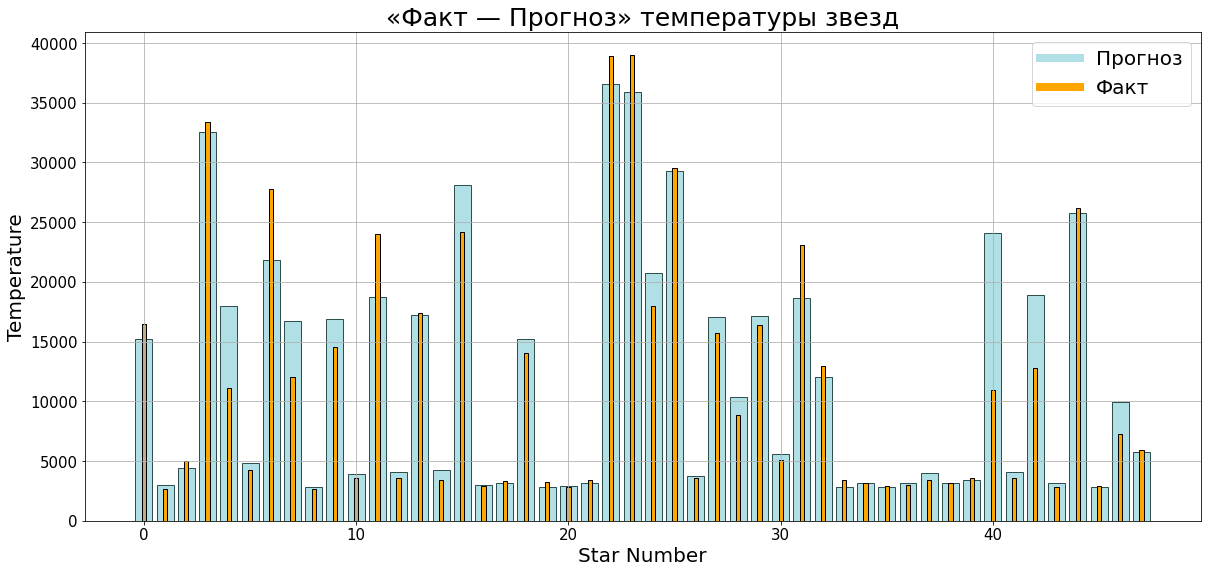

In [46]:
fig, ax = plt.subplots(figsize=(20, 9))
ax.bar(star_num, predictions, color='powderblue', edgecolor='darkslategray') #Предсказанные значения 
ax.bar(star_num, actual, color='orange', edgecolor='black', width = 0.2) #Фактические значения 
ax.tick_params(axis='both', labelsize=15)

ax.set_xlabel('Star Number', fontsize=20)
ax.set_ylabel('Temperature', fontsize=20)
ax.set_title('«Факт — Прогноз» температуры звезд', fontsize=25)
ax.grid(True)

# Создание объектов Line2D для легенды
pred_legend = Line2D([0], [0], color='powderblue', linewidth=8, label='Прогноз')
act_legend = Line2D([0], [0], color='orange', linewidth=8, label='Факт')
ax.legend(handles=[pred_legend, act_legend], fontsize=20)  # Добавление легенды

plt.show()

**Вывод:**

Из графика видно, что нейронная сеть прогнозирует температуру достаточно точно.
Фактическая метрика качества RMSE = 3004, что является лучшеим показателем, чем метрика требуемая по проекту. (Требуемая етрика качества RMSE = 4500)

# Улучшение сети.


## Dropout

В архитектуру нейронной сети внедряется dropout. Методом перебора определяется наилучший гиперпараметр.

In [47]:
#количество эпох обучения нейронки
for p in np.arange(0, 0.5, 0.1):
    print(f'Значение dropout: {p}')
    best_rmse = float('inf')
    net_dropout = NeuralNet(*net_layers, p) #добавление Dropout к слоям модели
    optimizer = torch.optim.Adam(net_dropout.parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()

    best_rmse = float('inf')
    patience = 10  #количество эпох без улучшений после которых обучение будет остановлено
    patience_counter = 0

    for epoch in range(num_epoch):
        net_dropout.train()
        optimizer.zero_grad() #Обнуление градиентов

        predictions_train = net_dropout.forward(X_train).flatten()

        loss_value = loss_function(predictions_train, y_train)
        loss_value.backward()

        optimizer.step()

        if epoch%10 == 0:
            with torch.no_grad():

                net_dropout.eval()
                predictions_val = net_dropout.forward(X_valid).flatten()
                rmse = torch.sqrt(loss_function(predictions_val, y_valid))

                if epoch%500 == 0:
                    print(f'RMSE for {epoch+500} epoch: {rmse:.0f}(K)')

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = copy.deepcopy(net_dropout.state_dict())  # Сохраняем веса модели только если RMSE улучшился
                    patience_counter = 0
                else:
                    patience_counter += 1

                #если RMSE не улучшился в течение заданного количества эпох, останавливаем обучение
                if patience_counter >= patience:
                    print("Early stopping")
                    break

    # Восстанавливаем лучшую модель
    net_dropout.load_state_dict(best_model)
    net_dropout.eval()
    predictions_val = net_dropout.forward(X_valid).flatten()
    rmse = torch.sqrt(loss_function(predictions_val, y_valid))
    print(f'Best RMSE: {rmse:.0f}(K)')
    print('_________________________________________________________________________________')

Значение dropout: 0.0
RMSE for 500 epoch: 15253(K)
RMSE for 1000 epoch: 11835(K)
RMSE for 1500 epoch: 7394(K)
RMSE for 2000 epoch: 5724(K)
RMSE for 2500 epoch: 3686(K)
RMSE for 3000 epoch: 3066(K)
RMSE for 3500 epoch: 2944(K)
RMSE for 4000 epoch: 2855(K)
Early stopping
Best RMSE: 2822(K)
_________________________________________________________________________________
Значение dropout: 0.1
RMSE for 500 epoch: 15253(K)
RMSE for 1000 epoch: 9250(K)
RMSE for 1500 epoch: 7429(K)
RMSE for 2000 epoch: 6945(K)
RMSE for 2500 epoch: 6464(K)
Early stopping
Best RMSE: 6143(K)
_________________________________________________________________________________
Значение dropout: 0.2
RMSE for 500 epoch: 15254(K)
RMSE for 1000 epoch: 15253(K)
RMSE for 1500 epoch: 15252(K)
RMSE for 2000 epoch: 15251(K)
RMSE for 2500 epoch: 15251(K)
RMSE for 3000 epoch: 15250(K)
RMSE for 3500 epoch: 15250(K)
RMSE for 4000 epoch: 15249(K)
RMSE for 4500 epoch: 15249(K)
RMSE for 5000 epoch: 15248(K)
RMSE for 5500 epoch: 1524

In [48]:
#Добавление. датасет с эксперементальными данными результато использоания Dropout
dropout_data = {'Количество эпох': 10000,
            '1-й скрытый слой' : 36,
            '2-й скрытый слой' : 12,
            '3-й скрытый слой' : 8,
            '4-й скрытый слой' : 2,
             '1-я ф-я актиации'  : 'SiLU',
             '2-я ф-я актиации'  : 'SiLU',
             '3-я ф-я актиации'  : 'SiLU',
             '4-я ф-я актиации'  : 'SiLU',
            'Улучшения модели' : 'Dropout - 0.0',
            'RMSE' : 2823}

analys_data = analys_data.append(dropout_data, ignore_index=True)
analys_data

/var/folders/th/9xw9c71j3d34kscxr4b5q7m80000gn/T/ipykernel_44322/3223779514.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analys_data = analys_data.append(dropout_data, ignore_index=True)


,Количество эпох,1-й скрытый слой,2-й скрытый слой,3-й скрытый слой,4-й скрытый слой,1-я ф-я актиации,2-я ф-я актиации,3-я ф-я актиации,4-я ф-я актиации,Улучшения модели,RMSE
0,1000,36,12,0,0,SiLU,SiLU,-,-,-,15649
1,1000,36,12,0,0,SiLU,ReLU,-,-,-,12715
2,10000,36,12,0,0,SiLU,SiLU,-,-,-,4114
3,10000,36,12,0,0,SiLU,SiLU,-,-,-,4965
4,10000,24,8,0,0,SiLU,SiLU,-,-,-,5178
5,10000,42,18,0,0,SiLU,SiLU,-,-,-,4252
6,10000,36,12,8,0,SiLU,SiLU,SiLU,-,-,3751
7,10000,36,12,8,0,SiLU,SiLU,ReLU,-,-,4060
8,10000,36,12,8,2,SiLU,SiLU,SiLU,SiLU,-,2985
9,10000,36,12,8,2,SiLU,SiLU,SiLU,SiLU,Dropout - 0.0,2823


**Вывод:**

Dropout не дал никакого прироста к метрике и ухудщил результат работы модели.

**Что-то не так сдесь делаю, слишком странные значения получаются.**

## Рабивка данных на Batch-и

In [49]:
#Определение размера батчий для цикла перебора.
for batch_size in range(25, 101, 25):
# Dataloader для тренировочной и валидационной части датасета 
    train_loader = torch.utils.data.DataLoader(dataset=X_train, 
                                               batch_size=batch_size, 
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=X_valid, 
                                              batch_size=batch_size, 
                                              shuffle=False)
    
    # Цикл обучения
    total_step = len(train_loader)
    
    

In [50]:
#Определение размера батчий для цикла перебора.

for batch_size in range(25, 101, 25):
    best_rmse = float('inf')
    print(f'Размер батча - {batch_size}')
    num_batches = ceil(len(X_train)/batch_size)
    for epoch in range(num_epoch):
        order = np.random.permutation(len(X_train)) #Случайная перестановка индексов объектов
        for batch_idx in range(num_batches):
            start_index =  batch_idx*batch_size #Номер стартового объекта батча
            optimizer.zero_grad()
            
            batch_indexes = order[start_index : start_index+batch_size] #Индексы объектов текущего обатча
            
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            
            net.train()
            optimizer.zero_grad() #Обнуление градиентов

            predictions_train = net.forward(X_batch).flatten()

            loss_value = loss_function(predictions_train, y_batch)
            loss_value.backward()

            optimizer.step()
            
            if epoch%10 == 0:
                with torch.no_grad():

                    net.eval()
                    predictions_val = net.forward(X_valid).flatten()
                    rmse = torch.sqrt(loss_function(predictions_val, y_valid))

                    if epoch%500 == 0:
                        print(f'RMSE for {epoch+500} epoch: {rmse:.0f}(K)')

                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_model = copy.deepcopy(net.state_dict())  # Сохраняем веса модели только если RMSE улучшился
                        patience_counter = 0
                    else:
                        patience_counter += 1

                    #если RMSE не улучшился в течение заданного количества эпох, останавливаем обучение
                    if patience_counter >= patience:
                        break
                        
                        
    # Восстановление лучшей модели
    net.load_state_dict(best_model)
    net.eval()
    predictions_val = net.forward(X_valid).flatten()
    rmse = torch.sqrt(loss_function(predictions_val, y_valid))
    print(f'Best RMSE: {rmse:.0f}(K)')
    print('_________________________________________________________')

Размер батча - 25
RMSE for 500 epoch: 2985(K)
RMSE for 500 epoch: 2985(K)
RMSE for 500 epoch: 2985(K)
RMSE for 500 epoch: 2985(K)
RMSE for 500 epoch: 2985(K)
RMSE for 500 epoch: 2985(K)
RMSE for 500 epoch: 2985(K)
RMSE for 500 epoch: 2985(K)
RMSE for 1000 epoch: 2985(K)
RMSE for 1500 epoch: 2985(K)
RMSE for 2000 epoch: 2985(K)
RMSE for 2500 epoch: 2985(K)
RMSE for 3000 epoch: 2985(K)
RMSE for 3500 epoch: 2985(K)
RMSE for 4000 epoch: 2985(K)
RMSE for 4500 epoch: 2985(K)
RMSE for 5000 epoch: 2985(K)
RMSE for 5500 epoch: 2985(K)
RMSE for 6000 epoch: 2985(K)
RMSE for 6500 epoch: 2985(K)
RMSE for 7000 epoch: 2985(K)
RMSE for 7500 epoch: 2985(K)
RMSE for 8000 epoch: 2985(K)
RMSE for 8500 epoch: 2985(K)
RMSE for 9000 epoch: 2985(K)
RMSE for 9500 epoch: 2985(K)
RMSE for 10000 epoch: 2985(K)
Best RMSE: 2985(K)
_________________________________________________________
Размер батча - 50
RMSE for 500 epoch: 2985(K)
RMSE for 500 epoch: 2985(K)
RMSE for 500 epoch: 2985(K)
RMSE for 500 epoch: 2985(K)

In [51]:
#Добавление. датасет с эксперементальными данными результато использоания Dropout
dropout_data = {'Количество эпох': 10000,
            '1-й скрытый слой' : 36,
            '2-й скрытый слой' : 12,
            '3-й скрытый слой' : 8,
            '4-й скрытый слой' : 2,
             '1-я ф-я актиации'  : 'SiLU',
             '2-я ф-я актиации'  : 'SiLU',
             '3-я ф-я актиации'  : 'SiLU',
             '4-я ф-я актиации'  : 'SiLU',
            'Улучшения модели' : 'Batch size - 100',
            'RMSE' : 2783}

analys_data = analys_data.append(dropout_data, ignore_index=True)
analys_data

/var/folders/th/9xw9c71j3d34kscxr4b5q7m80000gn/T/ipykernel_44322/1559413936.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analys_data = analys_data.append(dropout_data, ignore_index=True)


,Количество эпох,1-й скрытый слой,2-й скрытый слой,3-й скрытый слой,4-й скрытый слой,1-я ф-я актиации,2-я ф-я актиации,3-я ф-я актиации,4-я ф-я актиации,Улучшения модели,RMSE
0,1000,36,12,0,0,SiLU,SiLU,-,-,-,15649
1,1000,36,12,0,0,SiLU,ReLU,-,-,-,12715
2,10000,36,12,0,0,SiLU,SiLU,-,-,-,4114
3,10000,36,12,0,0,SiLU,SiLU,-,-,-,4965
4,10000,24,8,0,0,SiLU,SiLU,-,-,-,5178
5,10000,42,18,0,0,SiLU,SiLU,-,-,-,4252
6,10000,36,12,8,0,SiLU,SiLU,SiLU,-,-,3751
7,10000,36,12,8,0,SiLU,SiLU,ReLU,-,-,4060
8,10000,36,12,8,2,SiLU,SiLU,SiLU,SiLU,-,2985
9,10000,36,12,8,2,SiLU,SiLU,SiLU,SiLU,Dropout - 0.0,2823


## Графическое сравнение прогноза лучшей модели и фактических значений.

In [52]:
predictions = predictions_val.tolist()

In [53]:
predictions_flat = predictions_val.tolist() #Представляет из себя список списков.
actual = y_valid.tolist()
star_num =  [index for index, value in enumerate(actual)]

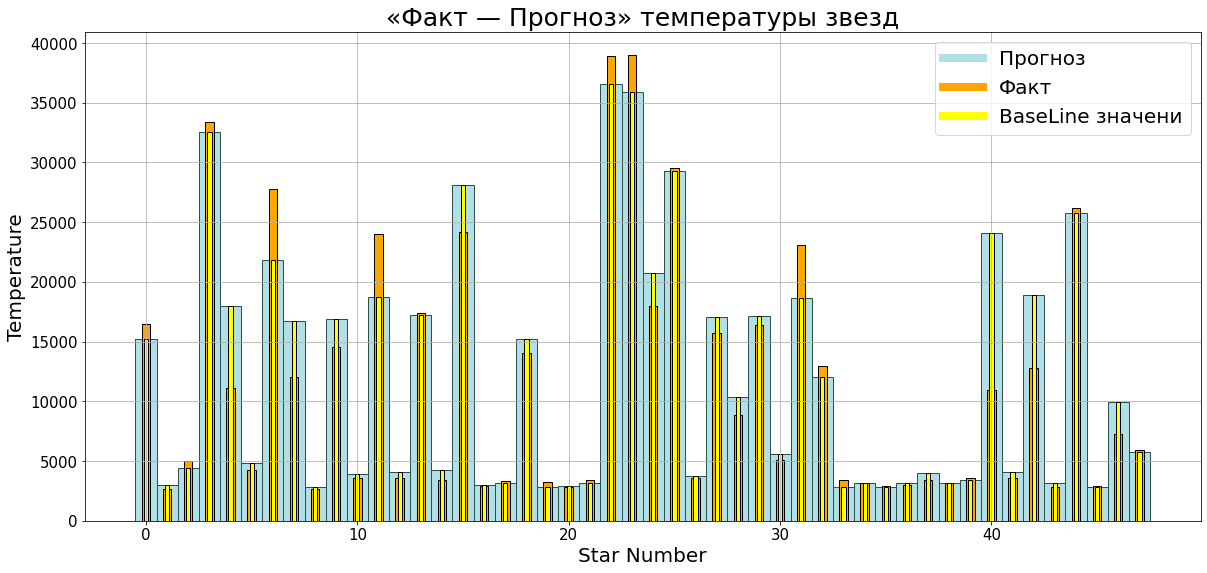

In [54]:
fig, ax = plt.subplots(figsize=(20, 9))
ax.bar(star_num, predictions, color='powderblue', edgecolor='darkslategray', width = 1) #Предсказанные значения 
ax.bar(star_num, actual, color='orange', edgecolor='black', width = 0.4) #Фактические значения 
ax.bar(star_num, predl_base, color='yellow', edgecolor='black', width = 0.2) #BaseLine значения

ax.tick_params(axis='both', labelsize=15)

ax.set_xlabel('Star Number', fontsize=20)
ax.set_ylabel('Temperature', fontsize=20)
ax.set_title('«Факт — Прогноз» температуры звезд', fontsize=25)
ax.grid(True)

# Создание объектов Line2D для легенды
pred_legend = Line2D([0], [0], color='powderblue', linewidth=8, label='Прогноз')
act_legend = Line2D([0], [0], color='orange', linewidth=8, label='Факт')
pred_base_legend = Line2D([0], [0], color='yellow', linewidth=8, label='BaseLine значени')
ax.legend(handles=[pred_legend, act_legend, pred_base_legend], fontsize=20)  # Добавление легенды

plt.show()

**Вывод:**

Из графика видно, что полсе улучшения модели нейронная сеть прогнозирует температуру с большей точностью. Распределние значений предсказаний выровнялось и стало более точным.

## Анализ улучшения модели.

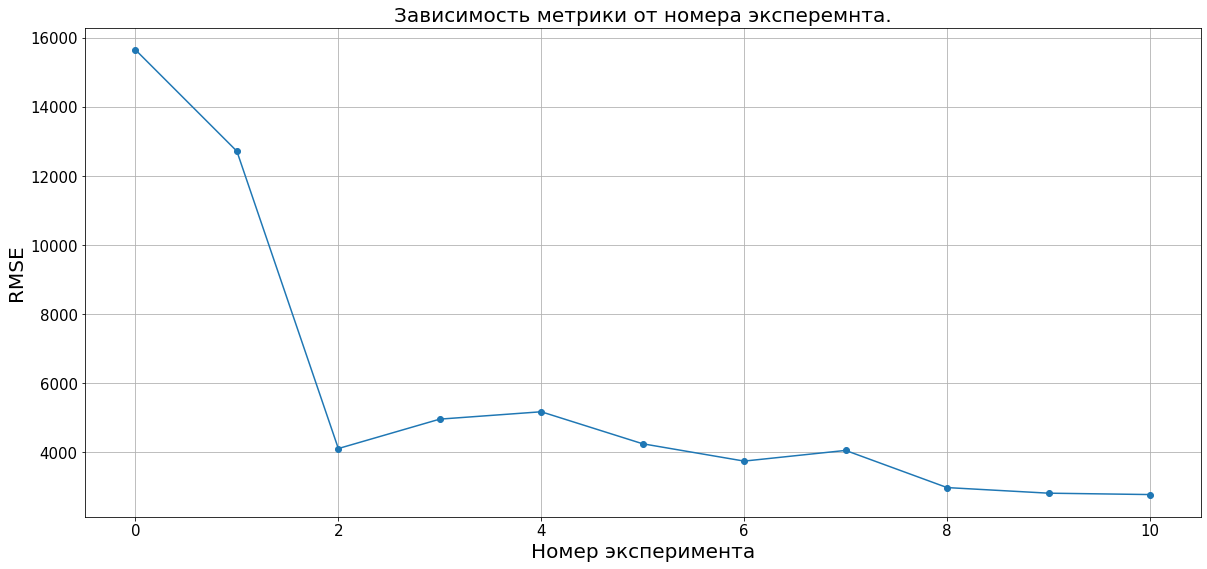

In [55]:
#Построения графика улучшения метрики в зависимости от номера эксперемента.

ax_x = analys_data.index.tolist()
ax_y = analys_data['RMSE']
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(ax_x, ax_y, marker='o', linestyle='-')

# Добавляем заголовок и подписи к осям
plt.title('Зависимость метрики от номера эксперемнта.', fontsize=20)
plt.xlabel('Номер эксперимента', fontsize=20)
plt.ylabel('RMSE', fontsize=20)
ax.grid(True)
ax.tick_params(axis='both', labelsize=15)


# Вывод.

Лучшей нейронной сетью для определения температы на поверхности звезд является модель с 4скрытыми слоями. Кол-во нейронов в каждом слое - 36, 12, 8, 2 соответственно. В сети для обучения используется 10.000 эпох с разбивкой на батчи размерами - 100 ед. 

Целевая метрика проекта RMSE = 4500.
Фактическая метрика RMSE = 2783. Что почти в 2 раза лучше требуемой.

Наиболлее важными параметрами нейронной сети являются - количество эпох и скрытых слоев. Они дают прирост метрики почти на 400%, что продемонстрировано на графики зависимости метрики от номера эксперимента.